In [330]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="5">     <b>I. Classification</b>

<font size="4">    <b>Loading the data</b>

In [2]:
pID = '11.2'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 0.1s
data_eeg_name_01 = '\data_s11_rp-win_-0.1-0_srate-250_modality-eeg.csv'
data_emg_name_01 = '\data_s11_rp-win_-0.1-0_srate-250_modality-emg.csv'
data_eye_name_01 = '\data_s11_rp-win_-0.1-0_srate-250_modality-eye.csv'

data_eeg_01 = pd.read_csv(path+pID+data_eeg_name_01)
data_remg_01 = pd.read_csv(path+pID+data_emg_name_01)
data_emg_01 = pd.concat([data_remg_01.iloc[:,:4], data_remg_01.iloc[:,4] + 0.270], axis=1)
data_emg_01.rename(columns={'EMG1':'Deltoïd', 'EMG2':'Biceps'}, inplace=True )
data_eye_01 = pd.read_csv(path+pID+data_eye_name_01)

# 1s
data_eeg_name_1 = '\data_s11_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name_1 = '\data_s11_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name_1 = '\data_s11_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg_1 = pd.read_csv(path+pID+data_eeg_name_1)
data_remg_1 = pd.read_csv(path+pID+data_emg_name_1)
data_emg_1 = pd.concat([data_remg_1.iloc[:,:4], data_remg_1.iloc[:,4] + 0.270], axis=1)
data_emg_1.rename(columns={'EMG1':'Deltoïd', 'EMG2':'Biceps'}, inplace=True )
data_eye_1 = pd.read_csv(path+pID+data_eye_name_1)

#Choose the data set to use, classifier EEG-EMG will only work if both modalities are on the safe timeframe
data_eeg = data_eeg_1
data_emg = data_emg_1
data_eye = data_eye_1

# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg))//win_eeg

# EMG Window 
win_emg = 250
win_emg_scaled = np.arange(len(data_emg))//win_emg

# EYE Window 
win_eye = 100
win_eye_scaled = np.arange(len(data_eye))//win_eye

<font size="4">    <b>Epoch representation, Highlight when the 2 classes are significatively differents ??</b>

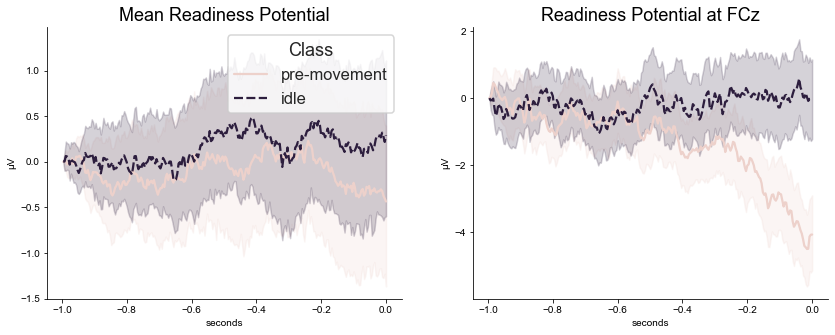

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")

electrodes = data_eeg.iloc[:,3:].mean(axis=1)
electrode = 'FCz'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
             hue="rp_class", style="rp_class",
             data=data_eeg)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data_eeg, legend=False)
g2.set(xlabel='seconds', ylabel='\u03bcV', title='Readiness Potential at '+ electrode)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

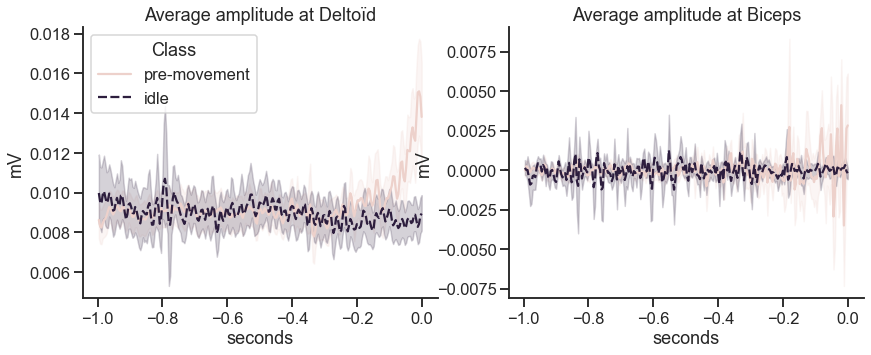

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")


electrode1 = 'Deltoïd'
electrode2 = 'Biceps'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrode1,
             hue="rp_class", style="rp_class",
             data=data_emg)
sns.despine()
g.set(xlabel='seconds', ylabel='mV', title='Average amplitude at '+ electrode1)

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode2,
             hue="rp_class", style="rp_class",
             data=data_emg, legend=False)
g2.set(xlabel='seconds', ylabel='mV', title='Average amplitude at '+ electrode2)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

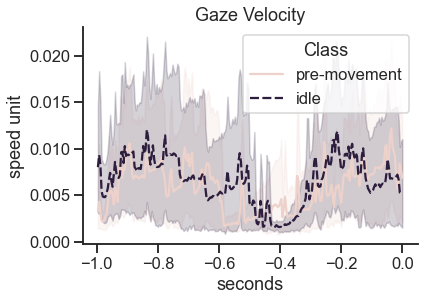

In [5]:
sns.set_theme(style="ticks")
sns.set_context("talk")

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y='GazeVel',
             hue="rp_class", style="rp_class",
             data=data_eye)
sns.despine()
g.set(xlabel='seconds', ylabel='speed unit', title='Gaze Velocity')

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

<font size="4">    <b>Clean feature definitions</b>

In [6]:
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

<font size="4">    <b>Not clean feature extraction</b>

In [7]:
#Waveform length
wl_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
b = np.zeros((win_emg))
wl_2 = np.zeros((len(data_emg['Deltoïd'])//win_emg))
c = np.zeros((win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    wl_1[j] = np.sum(b)
    wl_2[j] = np.sum(c)
    
    for i in range(win_emg):
        b[i] = abs(data_emg['Biceps'][(i+1)+j] - data_emg['Biceps'][i+j])
        c[i] = abs(data_emg['Deltoïd'][(i+1)+j] - data_emg['Deltoïd'][i+j])
        
#Mean absolute value slope
d_1 = data_emg.groupby(win_emg_scaled)['Biceps'].apply(mav)
mavs_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
d_2 = data_emg.groupby(win_emg_scaled)['Deltoïd'].apply(mav)
mavs_2 = np.zeros((len(data_emg['Deltoïd'])//win_emg))

for i in range((len(data_emg['Biceps'])//win_emg)-1):
    mavs_1[i] = d_1[i+1] - d_1[i]
    mavs_2[i] = d_2[i+1] - d_2[i]   

In [8]:
#Zero crossing
z_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
z_2 = np.zeros((len(data_emg['Biceps'])//win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    
    for i in range(win_emg):
        if data_emg['Biceps'][i+j] > 0 and data_emg['Biceps'][(i+1)+j] < 0 and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            z_1[j] += 1
        elif data_emg['Biceps'][i+j] < 0 and data_emg['Biceps'][(i+1)+j] > 0 and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            z_1[j] += 1
        else:
            z_1[j] += 0

        if data_emg['Deltoïd'][i+j]>0 and data_emg['Deltoïd'][(i+1)+j]<0 and abs(data_emg['Deltoïd'][i+j]-data_emg['Deltoïd'][(i+1)+j]) > 0.002:
            z_2[j] += 1
        elif data_emg['Deltoïd'][i+j]<0 and data_emg['Deltoïd'][(i+1)+j]>0 and abs(data_emg['Deltoïd'][i+j]-data_emg['Deltoïd'][(i+1)+j]) > 0.002:
            z_2[j] += 1
        else:
            z_2[j] += 0

In [9]:
#Slope sign change
ss_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
ss_2 = np.zeros((len(data_emg['Biceps'])//win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    
    for i in range(1,win_emg):
        if data_emg['Biceps'][i+j] > data_emg['Biceps'][(i-1)+j] and data_emg['Biceps'][i+j] > data_emg['Biceps'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_1 += 1
        elif data_emg['Biceps'][i+j] < data_emg['Biceps'][(i-1)+j] and data_emg['Biceps'][i+j] < data_emg['Biceps'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_1 += 1
        else:
            ss_1 += 0
        
        if data_emg['Deltoïd'][i+j] > data_emg['Deltoïd'][(i-1)+j] and data_emg['Deltoïd'][i+j] > data_emg['Deltoïd'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_2 += 1
        elif data_emg['Deltoïd'][i+j] < data_emg['Deltoïd'][(i-1)+j] and data_emg['Deltoïd'][i+j] < data_emg['Deltoïd'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_2 += 1
        else:
            ss_2 += 0

<font size="4">    <b>Feature extraction</b>
    
EEG: We want to extract 1 feature (mean) at each window having a size of 25 samples, so 10 times per epoch or per second.
    
    -> 10 features per epoch per channel.

EMG: We want to extract X features (5 ? See if selection) at each window having a size of 100 samples, so 10 times per epoch or per seconds.
    
    ->10 features per epoch per channel (better do features on win_size 25 ? so 40 features per epoch per channel).

In [10]:
# Write the features list we want to use for the EMG data.
feat_list = [rms, mini, maxi, mav, var]                                        #list for apply groupby
nfeat_list = ['rms', 'mini', 'maxi', 'mav', 'var', 'wl', 'mavs', 'zc', 'ssc']  #    , 'wl', 'mavs', 'zc', 'ssc'    accessory

muscle_1 =[None] * len(feat_list)
muscle_2 =[None] * len(feat_list)

# Exctract the features at each window size for each channel for each epoch and put them in a DataFrame

#EEG 1st DataFrame
win_eeg_mean = data_eeg.groupby(win_eeg_scaled).mean() 

#EMG 2nd DataFrame
for i in range(len(feat_list)):
    muscle_1[i] = data_emg.groupby(win_emg_scaled)['Biceps'].apply(feat_list[i])
    muscle_2[i] = data_emg.groupby(win_emg_scaled)['Deltoïd'].apply(feat_list[i])

muscle_1.append(wl_1) 
muscle_2.append(wl_2)
muscle_1.append(mavs_1) 
muscle_2.append(mavs_2)
muscle_1.append(z_1) 
muscle_2.append(z_2)
muscle_1.append(ss_1) 
muscle_2.append(ss_2)

m1 = pd.DataFrame(muscle_1, index=nfeat_list).transpose()
m2 = pd.DataFrame(muscle_2, index=nfeat_list).transpose()
mk = {'Biceps':m1, 'Deltoïd':m2}
muscles = pd.concat([m1,m2], axis=1, keys=mk.keys())
c_labels = data_emg.iloc[:,:3].groupby(win_emg_scaled).mean() # Labels for the EMG DataFrame

win_emg_mean = pd.concat([c_labels, muscles], axis=1)

<font size="4">    <b>Data frames</b>
    
From the imported data structure to the final structure adapted for the following classification.

In [11]:
#EEG
df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)

#EMG
df_emg = win_emg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_emg_mean.columns[3:].tolist())
df_emg.reset_index(inplace=True)

#EEG - EMG
df_eeg_emg = pd.concat([df_eeg, df_emg.iloc[:,2:]], axis=1)

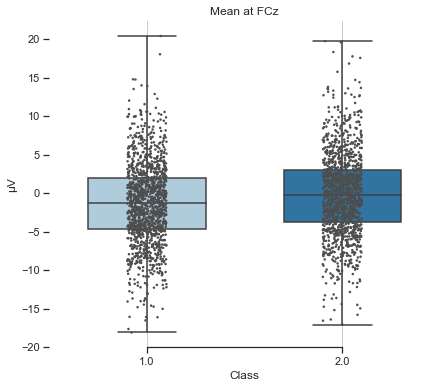

In [22]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = 'rp_class'
val_var = 'FCz'

F1 = sns.boxplot(x=group_var, y=val_var, data=win_eeg_mean,
              whis=[0, 100], width=.6, palette='Paired')
F1.set(title='Mean at '+ val_var)

    # Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=win_eeg_mean,
              size=2.5, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel='\u03bcV', xlabel='Class')
sns.despine(trim=True, left=True)

<font size="4">    <b>Linear Discriminent Analysis</b>

<font size="3">    <b>EEG</b>

In [13]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.6555555555555557
0.05749694331948157


<font size="3">    <b>EMG</b>

In [14]:
Xemg = df_emg.iloc[:,2:].values
yemg = np.asarray(df_emg['rp_class'])

clf_emg = LDA(solver='lsqr', shrinkage='auto')

clf_emg.fit(Xemg, yemg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_emg, Xemg, yemg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_emg = cross_val_predict(clf_emg, Xemg, yemg, cv=kfolds)

0.9666666666666666
0.02592592592592593


<font size="3">    <b>EEG - EMG</b>

In [15]:
X_eeg_emg = df_eeg_emg.iloc[:,2:].values
y_eeg_emg = np.asarray(df_emg['rp_class'])

clf_eeg_emg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg_emg.fit(X_eeg_emg, y_eeg_emg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg_emg, X_eeg_emg, y_eeg_emg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg_emg = cross_val_predict(clf_eeg_emg, X_eeg_emg, y_eeg_emg, cv=kfolds)

0.9518518518518517
0.02371527495345498


<font size="3">    <b>Classification metrics - EEG</b>

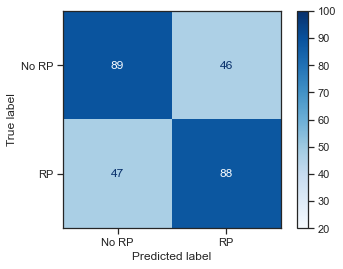

              precision    recall  f1-score   support

       No RP       0.65      0.66      0.66       135
          RP       0.66      0.65      0.65       135

    accuracy                           0.66       270
   macro avg       0.66      0.66      0.66       270
weighted avg       0.66      0.66      0.66       270



In [23]:
cm_eeg = confusion_matrix(y_true=yeeg, y_pred=pred_y_eeg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=yeeg, 
                                y_pred=pred_y_eeg, 
                                target_names=["No RP", "RP"]))

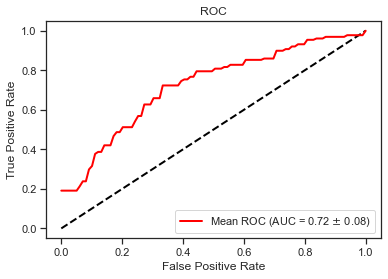

In [24]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xeeg,yeeg):
    prediction = clf_eeg.fit(Xeeg[train],yeeg[train]).predict_proba(Xeeg[test])
    fpr, tpr, t = roc_curve(yeeg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EMG</b>

              precision    recall  f1-score   support

       No RP       0.94      1.00      0.97       135
          RP       1.00      0.93      0.97       135

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270



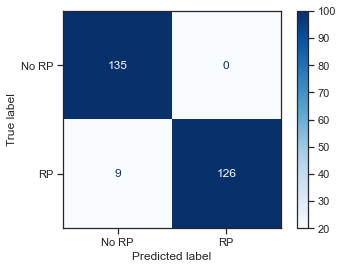

In [25]:
cm_emg = confusion_matrix(y_true=yemg, y_pred=pred_y_emg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_emg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
print(classification_report(y_true=yemg, 
                                y_pred=pred_y_emg, 
                                target_names=["No RP", "RP"]))

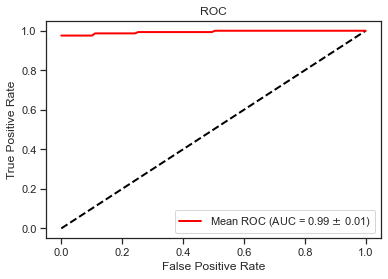

In [26]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xemg,yemg):
    prediction = clf_emg.fit(Xemg[train],yemg[train]).predict_proba(Xemg[test])
    fpr, tpr, t = roc_curve(yemg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EEG-EMG</b>

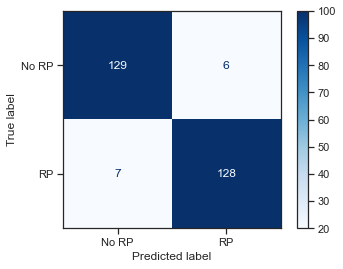

              precision    recall  f1-score   support

       No RP       0.95      0.96      0.95       135
          RP       0.96      0.95      0.95       135

    accuracy                           0.95       270
   macro avg       0.95      0.95      0.95       270
weighted avg       0.95      0.95      0.95       270



In [27]:
cm_eeg_emg = confusion_matrix(y_true=y_eeg_emg, y_pred=pred_y_eeg_emg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg_emg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=y_eeg_emg, 
                                y_pred=pred_y_eeg_emg, 
                                target_names=["No RP", "RP"]))

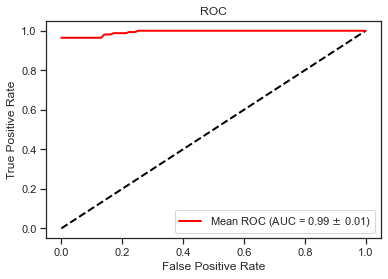

In [28]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(X_eeg_emg,y_eeg_emg):
    prediction = clf_eeg_emg.fit(X_eeg_emg[train],y_eeg_emg[train]).predict_proba(X_eeg_emg[test])
    fpr, tpr, t = roc_curve(y_eeg_emg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="5">     <b>II. Time serie representation (only done for EEG yet)</b>

Test the previously trained classifier on sliding windows over time.
Rather than testing the classifier on the whole stream of data, I will test it only on the interval [-2, 1] which should be enough, it would then speed up the processing delay.

This includes the following steps: Time interest definition - Baseline correction - Features extraction - Probability calculation - DataFrame and plot

<font size="3">    <b>Load the data and keep 20 best EEG</b>

In [332]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11.2/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11.2/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11.2/\chans_rp-win_-0.1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11.2/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None, dtype='float16')
velocity = pd.read_csv(pathm, header=None, dtype='float16')

# Select the best chans from the csv file to filter the eeg data
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg.iloc[i,:])
eeg_b = pd.DataFrame(eeg_b)

<font size="3">    <b>Extract the time frame of interest around the movement onset</b>

In [333]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
actual_onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(actual_onset), (b_onset + a_onset)))

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
epoch = np.zeros((len(actual_onset), (b_onset + a_onset), eeg_b.shape[0]))

for k in range(len(actual_onset)):
   
    for j in range(eeg_b.shape[0]):
    
        epoch[k, 0:(b_onset + a_onset), j] = eeg_b.iloc[j, actual_onset[k]-b_onset:actual_onset[k]+a_onset]
       
        actual_velocity[k, :] = velocity.iloc[0, actual_onset[k]-b_onset:actual_onset[k]+a_onset]

<font size="3">    <b>Baseline correction: I think this messes up the final result</b>

In [334]:
#Try base line correction at the beginning of the epoch only, and each 250 trial as well
epoch_cor = np.zeros((epoch.shape))

for k in range(len(actual_onset)):
    
    for j in range(eeg_b.shape[0]):
        
        for i in range((b_onset+a_onset)//250):
            
            epoch_cor[k, (250*i):250+(250*i), j] = epoch[k, (250*i):250+(250*i), j] - epoch[k, 250*i, j]

<font size="3">    <b>EEG Feature extraction</b>

In [335]:
# (i and j) Extract the feature of size win_eeg 10 times per window. Each window is 250 samples.
# (l) Slide the window of x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

fs = 250
nb_feat = fs//win_eeg
sld_size = 1

feat = np.zeros((len(epoch_cor), nb_feat*epoch_cor.shape[2], (epoch_cor.shape[1]//sld_size) - fs + sld_size))

for k in range(len(epoch_cor)):             # Onset index
    for l in range(feat.shape[2]):          # Window index
        for j in range(epoch_cor.shape[2]): # Channel index
            for i in range(nb_feat):        # Feature index
                feat[k, i+10*j, l] = np.mean(epoch_cor[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

<font size="3">    <b>Probability extraction</b>

In [336]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

proba = np.zeros((feat.shape[0], feat.shape[2]))

for k in range(len(epoch_cor)):
    
    for l in range(feat.shape[2]):
        
        proba[k, l] = clf_eeg.predict_proba(feat[k, :, l].reshape(1, -1))[0][1]

<font size="3">    <b>Final DataFrame and representation</b>

In [337]:
proba.shape

(149, 2751)

In [338]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba = np.reshape(proba, len(f_time))

m_velocity = actual_velocity[:, :proba.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data = np.zeros((len(f_time), 3))
f_data[:,0] = f_time
f_data[:,1] = f_velocity
f_data[:,2] = f_proba
final = pd.DataFrame(f_data, columns=['Time', 'Velocity', 'Probability'])
final

,Time,Velocity,Probability
0,-2.000,0.000007,0.180433
1,-1.999,0.000007,0.165673
2,-1.998,0.000007,0.160336
3,-1.997,0.000008,0.163424
4,-1.996,0.000008,0.154137
...,...,...,...
409894,0.746,0.000005,0.600679
409895,0.747,0.000008,0.645047
409896,0.748,0.000011,0.693561
409897,0.749,0.000013,0.746641


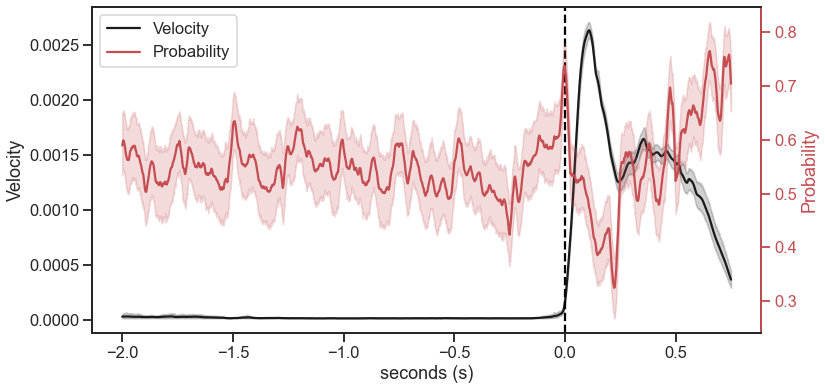

In [376]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)')

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

<font size="3">    <b>EMG Feature extraction on sliding windows, no clue on how I'm gonna do that</b>

<font size="3">    <b>Other option for baseline correction, after the feature extraction:</b>

In [ ]:
#Correct the baseline after mean feature extraction, I think it should work that way
cor = np.zeros((a.shape[0], a.shape[1]))
for k in range(a.shape[0]):
    for j in range(eeg_b.shape[0]):
        cor[k, nb_feat * j:nb_feat + nb_feat * j] = a[k, nb_feat * j:nb_feat + nb_feat * j] - \
                                                                    eeg_b.iloc[j, k * sld_size]

#Repeat the values to fit the number of time and velocity samples
cor_ext = np.repeat(cor, sld_size, axis=0)

Accélérer le script, faire la même pour EMG. Essayer de refaire la même chose avec intention intervale [-500ms - 0s]